# Noise Models

From the Spitzer handbook, we get:
$$SNR=0.86\sqrt{T_{exp}F},$$
with the cyro off, where $F$ is in ${\mu}\text{Jy}$ and $T_{exp}$ is in seconds.

$$\sigma_{F_{L}}=\ln{10}F\sigma_{I}/2.5$$

#### Zhu et al. 2017 sample:

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://doi.org/10.26093/cds/vizier.51540210 "https://vizier.cds.unistra.fr/viz-bin/VizieR") [ADS link](https://ui.adsabs.harvard.edu/abs/2018yCat..51540210Z/abstract)

"This research has made use of the VizieR catalogue access tool, CDS,
 Strasbourg, France (DOI : 10.26093/cds/vizier). The original description 
 of the VizieR service was published in 2000, A&AS 143, 23"

In [130]:
# the catalogue name in VizieR
CATALOGUE = "J/AJ/154/210"

Oh screw those guys, it's just the tables from their paper, not a real catalog.

## OGLE

Let's just web scrape a bunch of OGLE events and figure out the noise model.

In [131]:
#@title Imports and Setup

# system tools
import os
import sys
from io import StringIO
import time
from typing import Tuple, Callable, Optional, List
import shutil

# data analysis tools
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from scipy.optimize import minimize
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord

# web scrapping tools
import bs4 as bs
import urllib
import urllib.request
import pandas as pd

In [132]:
#@title Web scrapping functions

def get_data_url(event: str) -> str:
    '''Takes an event name and returns the URL for the data page.'''

    event = event.split('-') # split the event name into its components, seperated by '-'
    year = event[0]  # the first component is the year
    region = event[1].lower()  # the second component is region (e.g., blg or gd), which we need to make lower case.
    number = event[2]  #
    url = f'https://www.astrouw.edu.pl/ogle/ogle4/ews/{year}/{region}-{number}/phot.dat'

    return url

def fetch_event_data(url: str) -> pd.DataFrame:
    '''Takes a url and returns the data as a pandas dataframe.'''

    # Read the data from the URL
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')

    # Convert the data to a pandas DataFrame
    #df = pd.read_csv(StringIO(data), delim_whitespace=True, header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])
    df = pd.read_csv(StringIO(data), sep=r'\s+', header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])

    return df

# Test
event = '2017-BLG-0001'
event_data_url = get_data_url(event)
data = fetch_event_data(event_data_url)
print(data)

               HJD  I magnitude  magnitude error  seeing  sky level
0     2.457060e+06       17.644            0.034    7.59     1155.0
1     2.457061e+06       17.665            0.027    6.44      945.0
2     2.457061e+06       17.652            0.025    4.90     1305.0
3     2.457062e+06       17.682            0.024    5.85      934.0
4     2.457062e+06       17.702            0.023    5.10     1085.0
...            ...          ...              ...     ...        ...
2657  2.458047e+06       17.666            0.031    7.25      996.0
2658  2.458049e+06       17.661            0.018    4.33      703.0
2659  2.458049e+06       17.682            0.017    4.14      844.0
2660  2.458054e+06       17.672            0.035    6.18     1496.0
2661  2.458054e+06       17.686            0.041    7.01     1568.0

[2662 rows x 5 columns]


In [133]:
#@title More web scraping (this time for the EWS table)

def fetch_table_data(url):
    '''Takes a URL and returns the first table as a pandas DataFrame.'''
    source = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(source, 'html.parser')
    table = soup.find_all('table')
    df = pd.read_html(StringIO(str(table)))[0]

    return df

ews_url = "https://ogle.astrouw.edu.pl/ogle4/ews/ews.html"  # https://ogle.astrouw.edu.pl/ogle4/ews/2024/ews.html for last year
ews_df = fetch_table_data(ews_url)
print(ews_df)

# Adding a URL column to the data frame

# Add a new column to the EWS data frame ('ews_df'), using the column name 'event data url'.
ews_df['event data url'] = ews_df['Event'].apply(get_data_url)
print(ews_df)
print(min(ews_df['Tmax (HJD)']), max(ews_df['Tmax (HJD)']))
print(min(ews_df['Umin']), max(ews_df['Umin']))
print(min(ews_df['tau']), max(ews_df['tau']))

      Unnamed: 0          Event      Field  Star No   RA (J2000)  Dec (J2000)  \
0            NaN  2025-BLG-0001  BLG497.22    26223  17:19:44.68  -27:43:21.4   
1            NaN  2025-BLG-0002  BLG498.16    23293  17:17:24.61  -29:19:44.8   
2            NaN  2025-BLG-0003  BLG498.24   149001  17:18:03.34  -28:50:21.4   
3            NaN  2025-BLG-0004  BLG498.29     2940  17:20:03.15  -28:41:15.5   
4            NaN  2025-BLG-0005  BLG499.29    47835  17:19:54.58  -29:57:28.0   
...          ...            ...        ...      ...          ...          ...   
1364         NaN  2025-BLG-1338  BLG652.15    73712  17:38:55.50  -26:16:21.6   
1365         NaN  2025-BLG-1339  BLG652.15    74489  17:38:57.64  -26:17:16.1   
1366         NaN  2025-BLG-1340  BLG654.26    39817  17:37:38.89  -29:23:52.7   
1367         NaN  2025-BLG-1341  BLG661.20    58108  17:40:36.13  -33:20:52.6   
1368         NaN  2025-BLG-1342  BLG676.25    16729  17:38:17.56  -28:27:42.9   

       Tmax (HJD)      Tmax

In [134]:
N=50  # max N = len(ews_df)
OGLE_data = {}

for i in range(N):
    event = ews_df['Event'][i]
    print(event)
    print(ews_df.columns)
    url = ews_df['event data url'][i]
    data = fetch_event_data(url)
    OGLE_data[event] = data

2025-BLG-0001
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0002
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0003
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0004
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0005
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
   

In [135]:
print(OGLE_data.keys())
print(OGLE_data['2025-BLG-0001'])

dict_keys(['2025-BLG-0001', '2025-BLG-0002', '2025-BLG-0003', '2025-BLG-0004', '2025-BLG-0005', '2025-BLG-0006', '2025-BLG-0007', '2025-BLG-0008', '2025-BLG-0009', '2025-BLG-0010', '2025-BLG-0011', '2025-BLG-0012', '2025-BLG-0013', '2025-BLG-0014', '2025-BLG-0015', '2025-BLG-0016', '2025-BLG-0017', '2025-BLG-0018', '2025-BLG-0019', '2025-BLG-0020', '2025-BLG-0021', '2025-BLG-0022', '2025-BLG-0023', '2025-BLG-0024', '2025-BLG-0025', '2025-BLG-0026', '2025-BLG-0027', '2025-BLG-0028', '2025-BLG-0029', '2025-BLG-0030', '2025-BLG-0031', '2025-BLG-0032', '2025-BLG-0033', '2025-BLG-0034', '2025-BLG-0035', '2025-BLG-0036', '2025-BLG-0037', '2025-BLG-0038', '2025-BLG-0039', '2025-BLG-0040', '2025-BLG-0041', '2025-BLG-0042', '2025-BLG-0043', '2025-BLG-0044', '2025-BLG-0045', '2025-BLG-0046', '2025-BLG-0047', '2025-BLG-0048', '2025-BLG-0049', '2025-BLG-0050'])
              HJD  I magnitude  magnitude error  seeing  sky level
0    2.457822e+06       20.079            0.223    4.66       83.0
1   

In [136]:
def mag_to_flux(mag, band="I", obs="OGLE", zp=None):
    """Convert magnitude to flux.
    
    Parameter
    ---------
    mag : float
        The magnitude to convert.
    band : str
        The photometric band (default is "I").
    obs : str
        The observatory name (default is "OGLE").
    zp : float
        The zero point for the conversion (optional, overrides preset).

    Returns
    -------
    float
        The flux corresponding to the input magnitude.

    Raises
    ------
    ValueError
        If the band/observatory combination is unknown.
    """
    zps = {"I_OGLE": 18, "L_Spitzer": 25}  # example zero points for I and L bands

    zp_ = zps.get(f"{band}_{obs}", None)
    if zp is not None:
        zp_ = zp

    if zp_ is not None:
        return 10 ** ((zp_ - mag) / 2.5)
    else:
        raise ValueError(f"Unknown band/observatory combination: {band}, {obs}")

### OGLE I-band S/N model

ODR Fit Results:
Slope: 2028.551988 ± 2.401247
Intercept: 119.935004 ± 5.247288
Reduced Chi-squared: 0.561524


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_14853/3001891790.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


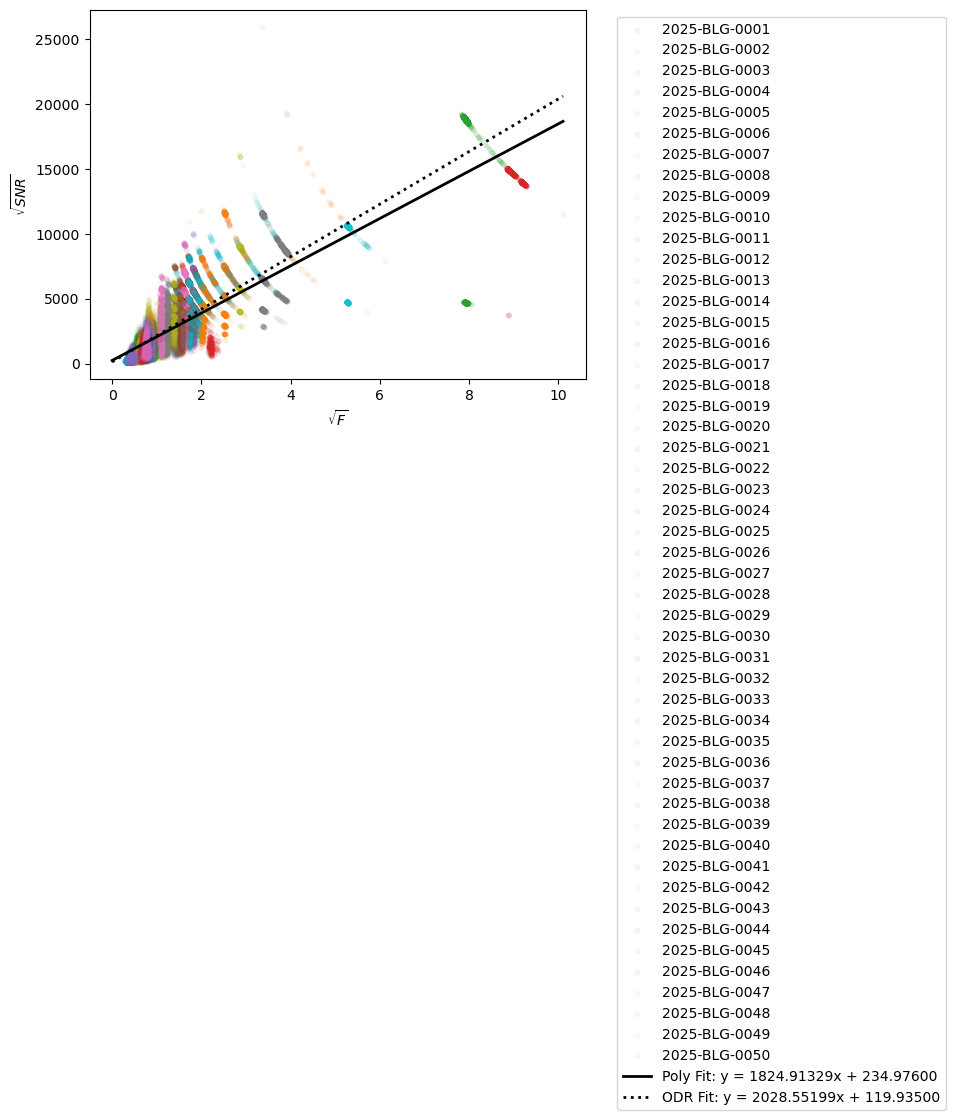

In [195]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    flux = mag_to_flux(data['I magnitude'].values, band="I", obs="OGLE")  # .values converts pandas Series to numpy array
    flux_err = flux * data['magnitude error'].values * np.log(10) / 2.5  # Convert mag error to flux error
    snr= flux / flux_err**2  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    #print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    #y = 2.5 /(np.log(10.0) * data['magnitude error'].values)  # .values converts to numpy array
    y = snr
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.05, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(y)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data
def line(x, m, c=0):
    y = m*x + c
    return y

def chi2(args, model, x, y):
    residuals = y - model(x, *args)
    return np.sum(residuals**2)/x**2

def lnprob(args, model, x, y):
    return -0.5 * chi2(args, model, x, y)

# emcee
# from emcee import EnsembleSampler
# ndim = 2
# nwalkers = 50
# nsteps = 1000
# nburn = 500
# p0 = [1800, 0.0]
# p0_state = p0 + 1e-4 * np.random.randn(nwalkers, ndim)  # initial guess for m and c

# sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(line, X, Y))
# sampler.run_mcmc(p0_state, nsteps)

xx = np.linspace(0, np.max(X), 100)
# yy = sampler.flatchain[nburn*nwalkers:, 0].mean() * xx + sampler.flatchain[nburn*nwalkers:, 1].mean()

# plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {sampler.flatchain[:, 0].mean():.5f}x + {sampler.flatchain[:, 1].mean():.5f}')   

# # plot the last 50 samples
# for i in range(50):
#     m = sampler.flatchain[-i, 0]
#     c = sampler.flatchain[-i, 1]
#     print(f"Sample {i}: m={m}, c={c}")
#     plt.plot(xx, line(xx, m, c), color='gray', alpha=0.3)

#fit a line using np.poly
coeffs = np.polyfit(X, Y, 1)
poly = np.poly1d(coeffs)
plt.plot(xx, poly(xx), color='black', linestyle='-', linewidth=2, label=f'Poly Fit: y = {coeffs[0]:.5f}x + {coeffs[1]:.5f}')

# orthogonal distance regression fit a linear line using the poly coeffs 
# for an initial guess using scipy ODR
from scipy import odr

# Define the linear function for ODR
def linear_func(p, x):
    """Linear function: y = p[0]*x + p[1]"""
    return p[0] * x + p[1]

# Create a Model
linear_model = odr.Model(linear_func)

# Create RealData object with weights (assuming equal weights for now)
# You could add error estimates here if you have them
data = odr.RealData(X, Y)

# Set up ODR with initial guess from polyfit
odr_obj = odr.ODR(data, linear_model, beta0=coeffs)

# Run the regression
output = odr_obj.run()

# Plot ODR fit
odr_coeffs = output.beta
plt.plot(xx, linear_func(odr_coeffs, xx), color='black', linestyle=':', linewidth=2, 
         label=f'ODR Fit: y = {odr_coeffs[0]:.5f}x + {odr_coeffs[1]:.5f}')

# Print fit results
print("ODR Fit Results:")
print(f"Slope: {odr_coeffs[0]:.6f} ± {output.sd_beta[0]:.6f}")
print(f"Intercept: {odr_coeffs[1]:.6f} ± {output.sd_beta[1]:.6f}")
print(f"Reduced Chi-squared: {output.res_var:.6f}")

plt.ylabel(r"$\sqrt{SNR}$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

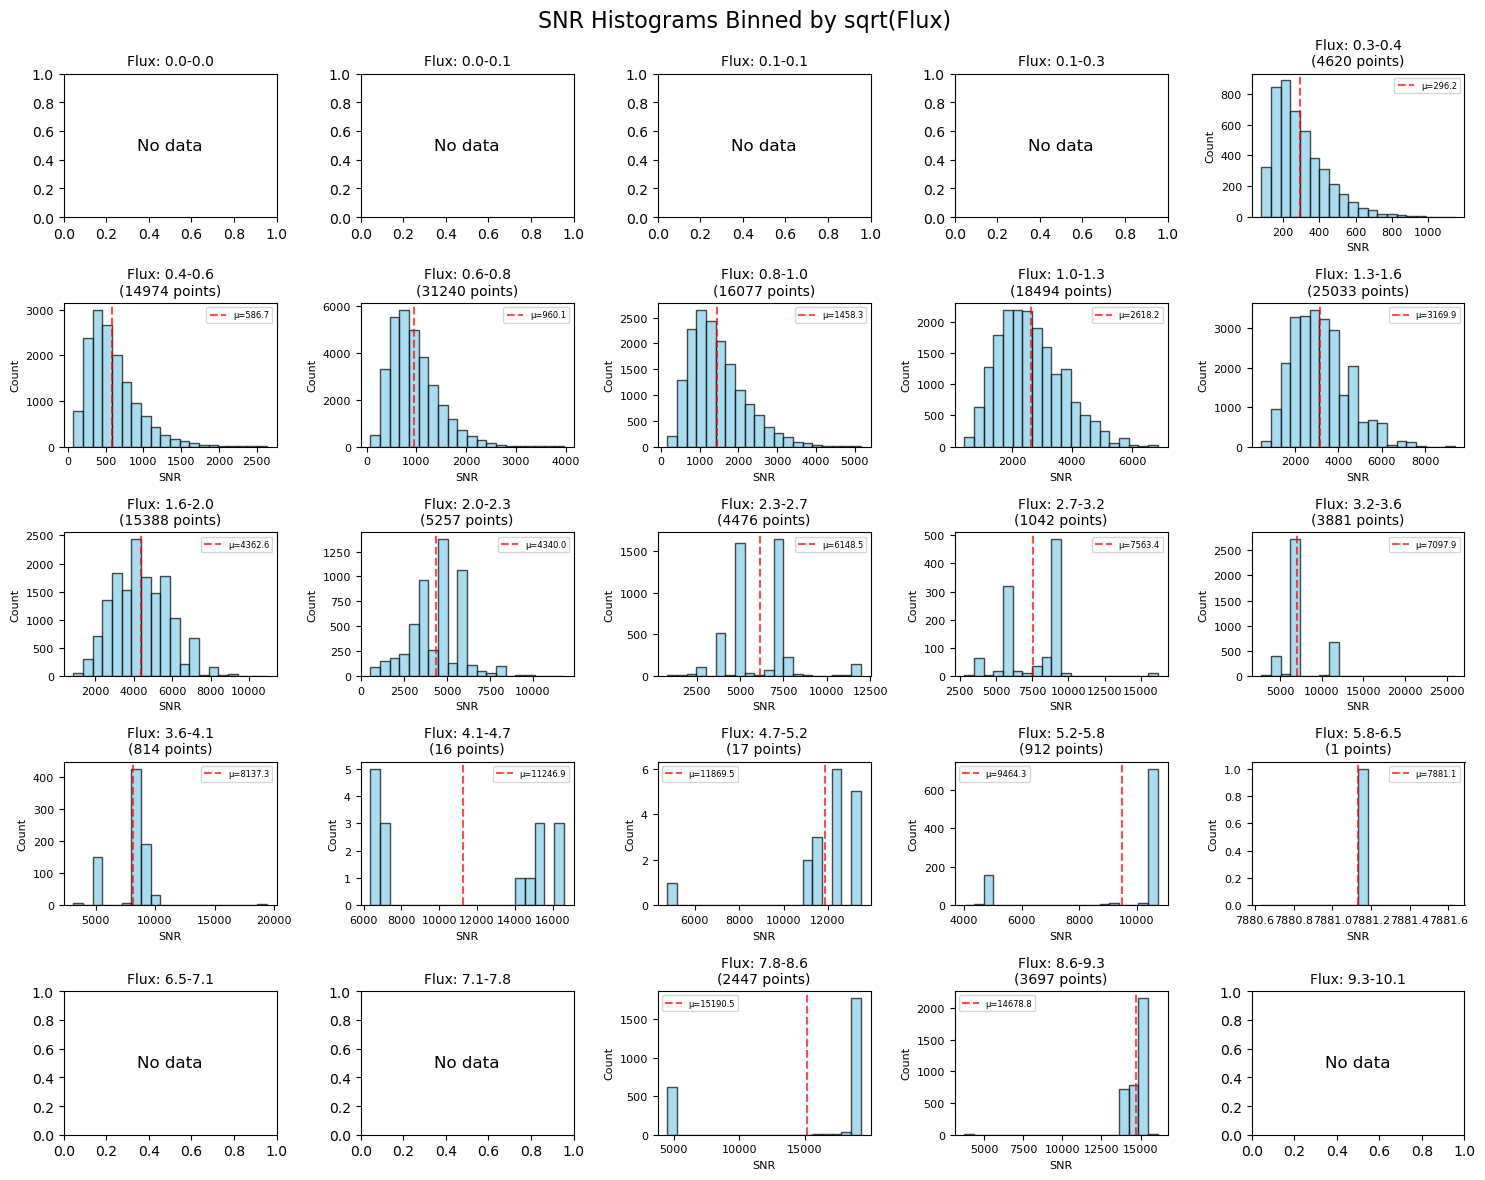

Summary of bins:
Bin  0: Flux    0.0-0.0, no data
Bin  1: Flux    0.0-0.1, no data
Bin  2: Flux    0.1-0.1, no data
Bin  3: Flux    0.1-0.3, no data
Bin  4: Flux    0.3-   0.4,  4620 points, SNR mean= 296.2, std= 147.4
Bin  5: Flux    0.4-   0.6, 14974 points, SNR mean= 586.7, std= 322.5
Bin  6: Flux    0.6-   0.8, 31240 points, SNR mean= 960.1, std= 475.5
Bin  7: Flux    0.8-   1.0, 16077 points, SNR mean=1458.3, std= 698.7
Bin  8: Flux    1.0-   1.3, 18494 points, SNR mean=2618.2, std=1063.0
Bin  9: Flux    1.3-   1.6, 25033 points, SNR mean=3169.9, std=1267.3
Bin 10: Flux    1.6-   2.0, 15388 points, SNR mean=4362.6, std=1413.9
Bin 11: Flux    2.0-   2.3,  5257 points, SNR mean=4340.0, std=1500.2
Bin 12: Flux    2.3-   2.7,  4476 points, SNR mean=6148.5, std=1785.8
Bin 13: Flux    2.7-   3.2,  1042 points, SNR mean=7563.4, std=1928.6
Bin 14: Flux    3.2-   3.6,  3881 points, SNR mean=7097.9, std=2198.9
Bin 15: Flux    3.6-   4.1,   814 points, SNR mean=8137.3, std=1662.6
Bin 16: Flu

In [196]:
# bin along the sqrt(F) x-axis - create 25 bins for 5x5 subplot grid
xx = np.linspace(0, np.sqrt(np.max(X)), 26)  # 26 edges for 25 bins
xx = xx**2  # convert back to flux space
binned_data = {}

# Create the 5x5 subplot figure
fig, axes = plt.subplots(5, 5, figsize=(15, 12))
fig.suptitle('SNR Histograms Binned by sqrt(Flux)', fontsize=16)

# Process each bin
for i in range(25):  # 25 bins for 5x5 grid
    mask = (X >= xx[i]) & (X < xx[i+1])
    
    # Calculate subplot position (row, col)
    row = i // 5  # Integer division gives row (0-4)
    col = i % 5   # Modulo gives column (0-4)
    
    ax = axes[row, col]
    
    if np.any(mask):
        # Get the SNR values for this flux bin
        snr_values = Y[mask]
        binned_data[f'bin_{i}'] = snr_values
        
        # Create histogram
        ax.hist(snr_values, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax.set_title(f'Flux: {xx[i]:.1f}-{xx[i+1]:.1f}\n({len(snr_values)} points)', fontsize=10)
        ax.set_ylabel('Count', fontsize=8)
        ax.set_xlabel('SNR', fontsize=8)
        ax.tick_params(labelsize=8)
        
        # Add some statistics
        mean_snr = np.mean(snr_values)
        std_snr = np.std(snr_values)
        ax.axvline(mean_snr, color='red', linestyle='--', alpha=0.7, label=f'μ={mean_snr:.1f}')
        ax.legend(fontsize=6)
    else:
        # No data in this bin
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=12)
        ax.set_title(f'Flux: {xx[i]:.1f}-{xx[i+1]:.1f}', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
mu, std = [], []
print("Summary of bins:")
for i in range(25):
    if f'bin_{i}' in binned_data:
        data = binned_data[f'bin_{i}']
        mu.append(np.mean(data))
        std.append(np.std(data))
        print(f"Bin {i:2d}: Flux {xx[i]:6.1f}-{xx[i+1]:6.1f}, "
              f"{len(data):5d} points, "
              f"SNR mean={np.mean(data):6.1f}, std={np.std(data):6.1f}")
    else:
        mu.append(np.nan)
        std.append(np.nan)
        print(f"Bin {i:2d}: Flux {xx[i]:6.1f}-{xx[i+1]:.1f}, no data")

Number of valid data points for fitting: 16
X_mu range: 0.33 to 8.19
Y_mu range: 296.18 to 15190.54
Fit parameters: slope=2272.16617, intercept=-464.71412


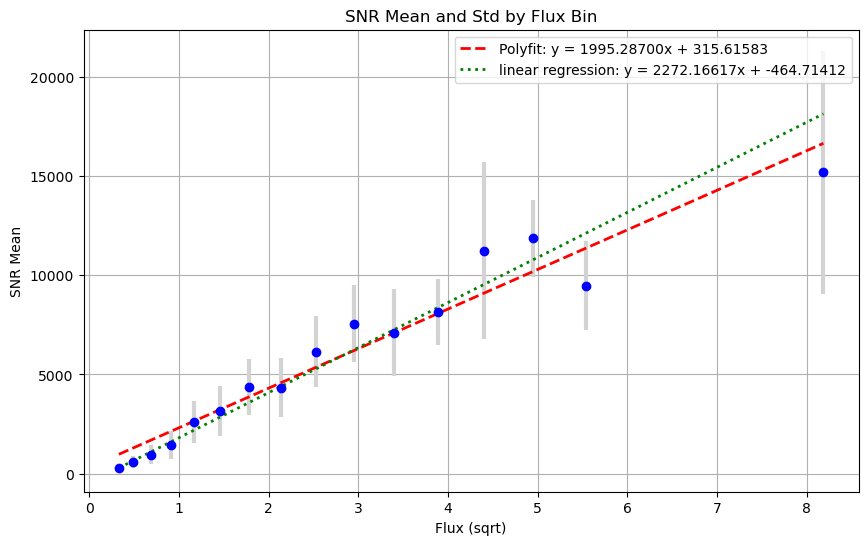

In [197]:
# plot sqrtF vs mu and std
import scipy.optimize as op

# Convert lists to numpy arrays for proper indexing
# remove the 19 value
mu = np.array(mu)
std = np.array(std)
# remove the 19 value
mu[19] = np.nan
std[19] = np.nan
mu[23] = np.nan
std[23] = np.nan

plt.figure(figsize=(10, 6))
# x is the midpoint of each bin in sqrt(Flux) space
x_mu = 0.5 * (xx[:-1] + xx[1:])
#plt.plot(x_mu[23], mu[23], "yo", zorder=5)  # using to locate specific points
plt.errorbar(x_mu, mu, yerr=std, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)

# fit a line to the data using std weighted linear regression
def chi2(p, x_mu, mu, std):
    return np.sum((linear_func(p, x_mu) - mu) ** 2 / std ** 2)

nan_mask = ~np.isnan(mu) & ~np.isnan(std) & (std > 0)  # mask to ignore NaNs and std<=0
X_mu = x_mu[nan_mask]
Y_mu = mu[nan_mask]
Y_std = std[nan_mask]

print(f"Number of valid data points for fitting: {len(X_mu)}")
print(f"X_mu range: {X_mu.min():.2f} to {X_mu.max():.2f}")
print(f"Y_mu range: {Y_mu.min():.2f} to {Y_mu.max():.2f}")

poly_coeffs = np.polyfit(X_mu, Y_mu, 1)
x_fit = np.linspace(np.min(x_mu[nan_mask]), np.max(x_mu[nan_mask]), 100)
plt.plot(x_fit, np.polyval(poly_coeffs, x_fit), color='red', linestyle='--', linewidth=2,
            label=f'Polyfit: y = {poly_coeffs[0]:.5f}x + {poly_coeffs[1]:.5f}')

# fit with Nelder-mead
p0 = [poly_coeffs[0], poly_coeffs[1]]  # initial guess from polyfit
result = op.minimize(chi2, p0, args=(X_mu, Y_mu, Y_std), method='Nelder-Mead')
popt = result.x
print(f"Fit parameters: slope={popt[0]:.5f}, intercept={popt[1]:.5f}")

# Calculate x range for plotting fit line
x_fit = np.linspace(np.min(x_mu[nan_mask]), np.max(x_mu[nan_mask]), 100)
plt.plot(x_fit, linear_func(popt, x_fit), color='green', linestyle=':', linewidth=2, 
            label=f'linear regression: y = {popt[0]:.5f}x + {popt[1]:.5f}')

plt.ylabel('SNR Mean')
plt.xlabel('Flux (sqrt)')
plt.title('SNR Mean and Std by Flux Bin')
plt.legend()
plt.grid()
plt.show()

MLE: [2308.80200014 -486.51594797], 16th percentile: [2095.99333027 -646.343974  ], 84th percentile: [2501.0860315 -319.8717727]
uncertainties: +([186.54096884 167.64439578]), -([193.64452413 166.17105297])


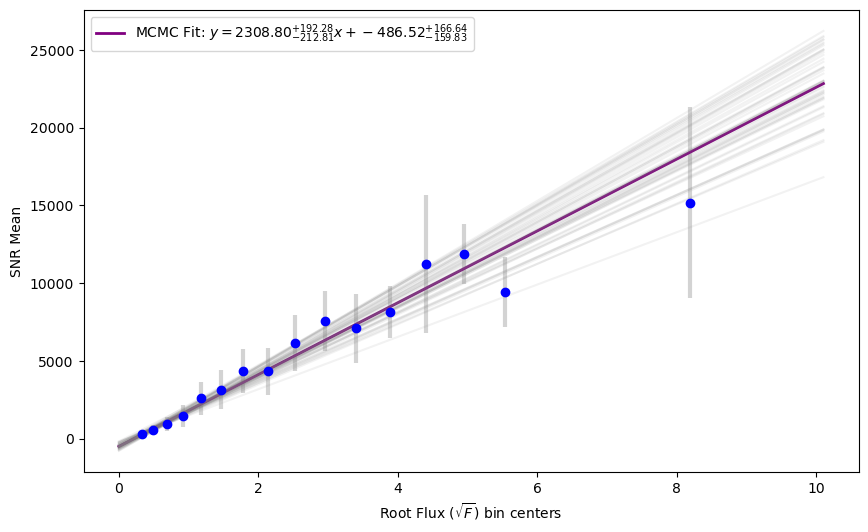

In [193]:
# use emcee to fit a posterior distribution
import emcee

def lnprob(theta, x, y, yerr):
    """Log-probability function for emcee."""
    # Unpack parameters
    m, b = theta
    # Compute the log-probability
    chi2_val = np.nansum(((y - (m * x + b)) / yerr) ** 2)
    if np.isnan(chi2_val):
        return -np.inf
    return -0.5 * chi2_val

p0 = popt
ndim = len(p0)
nwalkers = 50
pos = [p0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_mu, mu, std))

plt.figure(figsize=(10, 6))
# x is the midpoint of each bin in sqrt(Flux) space
plt.errorbar(x_mu, mu, yerr=std, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)

sampler.run_mcmc(pos, 1000)
pos = sampler.get_chain()[-100:, :, :]
pos = pos.reshape((-1, ndim))
mle = np.percentile(pos, 50, axis=0)
p16 = np.percentile(pos, 16, axis=0)
p84 = np.percentile(pos, 84, axis=0)
print(f'MLE: {mle}, 16th percentile: {p16}, 84th percentile: {p84}')
print(f'uncertainties: +({upper}), -({lower})')
lower = mle - p16
upper = p84 - mle

plt.plot(xx, linear_func(mle, xx), color='purple', linestyle='-', linewidth=2, 
            label=f'MCMC Fit: $y = {mle[0]:.2f}^{{+{upper[0]:.2f}}}_{{-{lower[0]:.2f}}}x + {mle[1]:.2f}^{{+{upper[1]:.2f}}}_{{-{lower[1]:.2f}}}$')

# plot the walkers in the last state
for i in range(nwalkers):
    n = np.random.randint(0, 100)
    nw = np.random.randint(0, nwalkers)
    plt.plot(xx, pos[n*nwalkers+nw, 0] * xx + pos[n*nwalkers+nw, 1], color='gray', alpha=0.1)

plt.ylabel('SNR Mean')
plt.xlabel(f'Root Flux ($\sqrt{{F}}$) bin centers')
plt.legend()
plt.savefig('mcmc_fit_OGLE_SN_model.png')

ODR Fit Results:
Slope: 559.374250 ± 25.782801
Intercept: 230.159888 ± 76.645131
Reduced Chi-squared: 0.098713


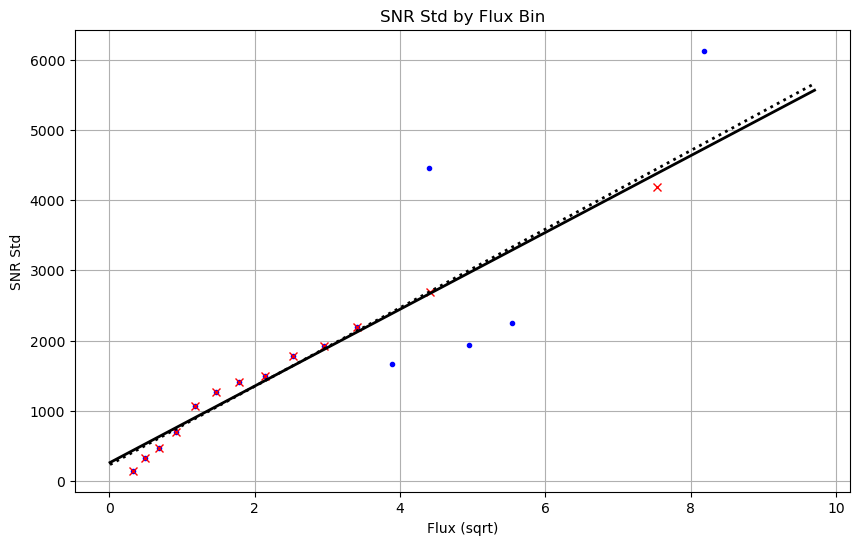

In [ ]:
# plot x vs std
plt.figure(figsize=(10, 6))
plt.plot(x_mu, std, 'b.')
# bin 15 - 17
std_binned = np.zeros(13)
x_binned = np.zeros(13)
std_binned[0:11] = std[4:15]
std_binned[-2] = np.sum(std[15:18])/3.0
last_points = std[18:]
last_points = last_points[~np.isnan(last_points)]
last_points = last_points[last_points>100]
std_binned[-1] = np.nansum(last_points)/len(last_points)
x_binned[0:11] = x_mu[4:15]
x_binned[-2] = np.mean(x_mu[15:18])
x_binned[-1] = np.mean(x_mu[18:])

plt.plot(x_binned, std_binned, 'rx')
# find liner trend using odr
#fit a line using np.poly
coeffs = np.polyfit(x_binned, std_binned, 1)
poly = np.poly1d(coeffs)
plt.plot(x_mu, poly(x_mu), color='black', linestyle='-', linewidth=2, label=f'Poly Fit: y = {coeffs[0]:.5f}x + {coeffs[1]:.5f}')

# orthogonal distance regression fit a linear line using the poly coeffs 
# for an initial guess using scipy ODR
from scipy import odr

# Define the linear function for ODR
def linear_func(p, x):
    """Linear function: y = p[0]*x + p[1]"""
    return p[0] * x + p[1]

# Create a Model
linear_model = odr.Model(linear_func)

# Create RealData object with weights (assuming equal weights for now)
# You could add error estimates here if you have them
data = odr.RealData(x_binned, std_binned)

# Set up ODR with initial guess from polyfit
odr_obj = odr.ODR(data, linear_model, beta0=coeffs)

# Run the regression
output = odr_obj.run()

# Plot ODR fit
odr_coeffs = output.beta
plt.plot(x_mu, linear_func(odr_coeffs, x_mu), color='black', linestyle=':', linewidth=2, 
         label=f'ODR Fit: y = {odr_coeffs[0]:.5f}x + {odr_coeffs[1]:.5f}')

# Print fit results
print("ODR Fit Results:")
print(f"Slope: {odr_coeffs[0]:.6f} ± {output.sd_beta[0]:.6f}")
print(f"Intercept: {odr_coeffs[1]:.6f} ± {output.sd_beta[1]:.6f}")
print(f"Reduced Chi-squared: {output.res_var:.6f}")


plt.ylabel('SNR Std')
plt.xlabel('Flux (sqrt)')
plt.title('SNR Std by Flux Bin')
plt.grid()
plt.show()

## Spitzer

In [ ]:
data_dir = "data/Spitzer/"

Spitzer_data = {}
for f in os.listdir(data_dir):
    if f.endswith(".dat") or f.endswith(".out"):
        event_id = f.split('.')[0]
        data = pd.read_csv(os.path.join(data_dir, f), header=None, sep=' ')
        
        if f.endswith(".out"):
            data = data.rename(columns={4: 'HJD_', 5: 'L flux', 6: 'flux error', 0: 'other1', 1: 'other2', 2: 'other3', 3: 'other4'})
            data = data[['HJD_', 'L flux', 'flux error']]
        else:
            # drop columns with NaN values
            data = data.dropna(axis=1)
            # get remaining column indexes
            remaining_cols = data.columns
            data = data.rename(columns={remaining_cols[0]: 'HJD_', remaining_cols[1]: 'L magnitude', remaining_cols[2]: 'magnitude error'})

            if event_id == "OB161195":
                zp = 18
            elif event_id == "OB161093":
                zp = 18.8
                
            data["L flux"] = mag_to_flux(data['L magnitude'].values, band="L", obs="Spitzer", zp=zp)
            data["flux error"] = data["L flux"] * data['magnitude error'].values * np.log(10) / 2.5

        # Process the data as needed
        Spitzer_data[event_id] = data

In [ ]:
print(Spitzer_data.keys())
Spitzer_data['OB161195'].head()
S = {
    'OB161195': 1.0,  # 0.65, 1.77
    'OB161093': 1.0,  # 0.9, 0.4
    'OB171038': 1.0
}

for event_id, data in Spitzer_data.items():
    err_rescaling = S.get(event_id, 1.0)
    data['flux error rescaled'] = data['flux error'] * err_rescaling


dict_keys(['OB171038', 'OB161195', 'OB161093'])


SNR (OB171038): min=275.08857494403844, max=472.5308110308972, mean=nan
SNR (OB161195): min=11.599745777330442, max=35.832878044822756, mean=19.58815839293461
SNR (OB161093): min=53.85596253760563, max=111.47188960555742, mean=75.68895753527079


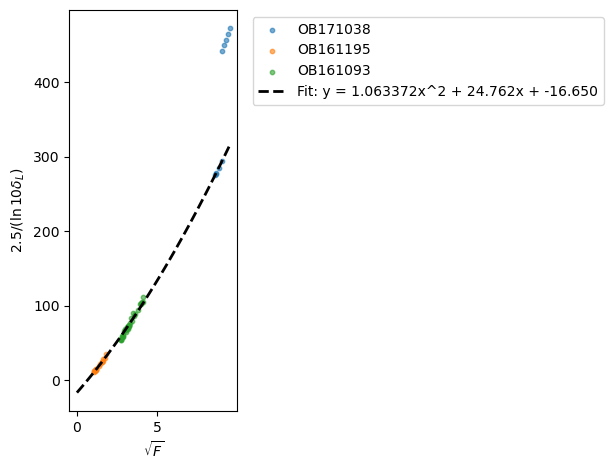

In [ ]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in Spitzer_data.items():
    flux = data['L flux'].values  # .values converts pandas Series to numpy array
    flux_err =data['flux error rescaled'].values
    snr= flux / flux_err  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    y = snr.copy()  # .values converts to numpy array
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.6, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(y)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data

m = np.polyfit(X[(Y<400)], Y[(Y<400)], 2)

xx = np.linspace(0, np.max(X), 100)
yy = m[0] * xx**2 + m[1] * xx + m[2]

#plt.plot(X[~((Y<400)*(X>5))], Y[~((Y<400)*(X>5))], 'kx')

plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {m[0]:.6f}x^2 + {m[1]:.3f}x + {m[2]:.3f}')

plt.ylabel(r"$2.5 /(\ln{10}\delta_{L})$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
#plt.xlim(8, 10)
plt.show()